Ok, let's build an Attention Tower — it's just like CNN tower, but with a lot of attentions!
It should generate sequences without conditioning on previous tokens.
So, representations should talk to each other along the way from inputs to outputs, deciding who is who.

In [1]:
import sys; sys.path.append('..')

In [2]:
import torch
import torch.nn as nn
from src.models.modules import Encoder
from src.models.layers import Linear

class AttentionTower(nn.Module):
    def __init__(self, max_len, vocab_src_len, vocab_trg_len, n_encoders=1, **kwargs):
        super(AttentionTower, self).__init__()
        self.encoders = [Encoder(vocab_src_len, max_len, **kwargs) for _ in range(n_encoders)]
        self.out_embs = Linear(kwargs['d_model'], vocab_trg_len, bias=False)
        
    def forward(self, seq):
        logits = []
        
        for encoder in self.encoders:
            seq, *_ = encoder(seq)
            logits.append(self.out_embs(seq))
        
        return logits

In [3]:
from torchtext import data, datasets

max_len = 100
src = data.Field(init_token='<bos>', eos_token='<eos>', fix_length=max_len)
trg = data.Field(init_token='<bos>', eos_token='<eos>', fix_length=max_len)

train = datasets.TranslationDataset(
    path='../data/generated/europarl',
    exts=('.en.tok.bpe.train', '.fr.tok.bpe.train'),
    fields=(src, trg))

val = datasets.TranslationDataset(
    path='../data/generated/europarl',
    exts=('.en.tok.bpe.val', '.fr.tok.bpe.val'),
    fields=(src, trg))

src.build_vocab(train)
trg.build_vocab(train)

# sort_by_len = lambda x: data.interleave_keys(len(x.src), len(x.trg))
batches = data.BucketIterator(dataset=train, batch_size=32, shuffle=True)

In [4]:
kwargs = {
    'd_model': 512,
}

model = AttentionTower(max_len, len(src.vocab), len(trg.vocab), n_encoders=3, **kwargs).cuda()

In [5]:
from src.utils.bleu import compute_bleu_for_sents

def indices_to_sent(indices, vocab):
    s = ' '.join([vocab.itos[i] for i in indices.data if i > 3])
    s = s.replace('@@ ', '')
    
    return s

def compute_bleu(model, batches):
    translations = []
    targets = []
    
    for batch in tqdm(iter(batches), total=len(batches)):
        logits = model(batch.src.transpose(0,1))
        preds = logits.max(dim=-1)[1]
        translations.extend([indices_to_sent(s, trg.vocab) for s in preds])
        targets.extend([indices_to_sent(s, trg.vocab) for s in batch.trg.transpose(0,1)])
            
    bleu = compute_bleu_for_sents(translations, targets)
    
    return bleu, translations, targets

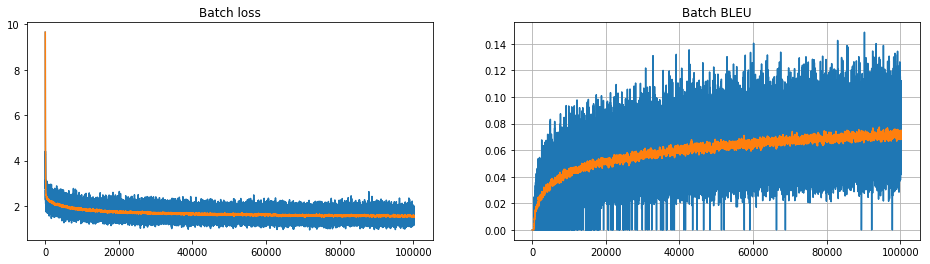

In [6]:
import math
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm; tqdm.monitor_interval = 0

from src.dataloaders import Batcher
from src.vocab import constants

optimizer = Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
loss_history = []
bleu_history = []
num_iters_done = 0
max_num_epochs = 5
plot_every = 10

try:
    for i in range(max_num_epochs):
        for batch in tqdm(iter(batches), leave=False, total=len(batches)):
            optimizer.zero_grad()
            logits = model(batch.src.transpose(0,1))
            targets = batch.trg.transpose(0,1).contiguous().view(-1).squeeze()
            loss = criterion(logits.view(-1, len(trg.vocab)), targets)
            loss.backward()
            optimizer.step()

            loss_history.append(loss.data[0])
            
            # Computing BLEU
            preds = logits.max(dim=-1)[1]
            translations = [indices_to_sent(s, trg.vocab) for s in preds]
            target_sents = [indices_to_sent(s, trg.vocab) for s in batch.trg.transpose(0,1)]
            bleu = compute_bleu_for_sents(translations, target_sents)
            bleu_history.append(bleu)

            if num_iters_done % plot_every == 0:
                clear_output(True)
                plt.figure(figsize=[16,4])
                
                plt.subplot(121)
                plt.title("Batch loss")
                plt.plot(loss_history)
                plt.plot(pd.DataFrame(np.array(loss_history)).ewm(span=100).mean())
                
                plt.subplot(122)
                plt.title("Batch BLEU")
                plt.plot(bleu_history)
                plt.plot(pd.DataFrame(np.array(bleu_history)).ewm(span=100).mean())
                
                plt.grid()
                plt.show()

            num_iters_done += 1
except KeyboardInterrupt:
    pass